# A Practical Guide for Single-Cell Data Analysis in Neurosciences

## Quality Control, Doublet Detection, and Normalization
### Learning Objectives:
- Load and explore single-cell RNA-seq data
- Understand quality control metrics
- **Detect and remove doublets using multiple methods**
- Filter low-quality cells and genes
- Normalize and log-transform data
- Identify highly variable genes



## Before You Begin

**Prerequisites**:
- Basic Python (variables, functions, loops)
- Basic biology (what is a gene? what is RNA?)
- NO prior single-cell experience required!


**What You'll Learn**:
By the end of this notebook, you will be able to:
1. **Load** single-cell RNA-seq data from standard formats (10X Genomics h5)
2. **Calculate** and interpret quality control (QC) metrics
3. **Detect and remove doublets** using multiple computational methods
4. **Filter** low-quality cells based on biological reasoning
5. **Normalize** data to make cells comparable
6. **Identify** highly variable genes for downstream analysis
7. **Explain WHY** each step is necessary (not just run the code!)

## The Big Picture: From Tissue to Insights
Single-cell RNA-seq (scRNA-seq) allows us to measure gene expression in individual cells, revealing cellular diversity hidden in bulk measurements.


**The Workflow**:
```
Biological Sample (mouse/human)
        ↓
  scRNA-seq Experiment (10X Genomics)
        ↓
  Raw Count Matrix (~15,000 cells × ~28,000 genes)
        ↓
  Quality Control ← YOU ARE HERE (Notebook 1)
        ↓
  Dimensionality Reduction (Notebook 2)
        ↓
  Clustering & Cell Type Identification (Notebook 3)
        ↓
  Biological Interpretation (Notebooks 4-6)
```

**Why Quality Control?**  
Not all droplets contain healthy, single cells. We must remove:
- Empty droplets (ambient RNA)
- Dead/dying cells (leaked cytoplasm)
- Doublets (2+ cells captured together)
- Low-quality libraries (too few reads)

**The Goal**: Start with ~15,000 droplets → End with ~12,000-13,000 high-quality cells ready for analysis

## Dataset Information:
Based on the paper: https://www.sciencedirect.com/science/article/pii/S0168010225000653
- GSM4635080_P1_S1: Control sample
- GSM4635087_Fezf2KO_P1: Fezf2 knockout sample

## Biological Context: The Fezf2 Story
**What is this dataset about?**

We're analyzing mouse cerebral cortex at postnatal day 1 (P1), comparing:
- **Wild-type (WT)**: Normal cortical development
- **Fezf2 knockout (KO)**: Loss of a critical transcription factor

**What is Fezf2?**
- **Gene**: Fez family zinc finger 2
- **Function**: Transcription factor that specifies deep-layer cortical neuron identity
- **Expression**: Layer 5 subcerebral projection neurons
- **Role**: Required for corticospinal motor neurons (neurons that connect brain to spinal cord)

**What happens when Fezf2 is knocked out?**
- Layer 5 neurons **lose** subcerebral identity
- They adopt an alternative fate: **callosal neurons** (connect left/right hemispheres)
- Molecular change: Loss of deep-layer markers (Fezf2, Bcl11b), gain of upper-layer markers (Satb2)
- Anatomical consequence: No projections to spinal cord

**Why does this matter for our analysis?**
As we analyze this data, we should see:
- Similar total cell numbers (neurons still form, just wrong type)
- Changes in layer 5 neuron gene expression
- Potential compensation mechanisms in other cell types

**Dataset Source**: [Di Bella et al. 2021, Nature](https://www.nature.com/articles/s41586-021-03670-5)  
This paper used scRNA-seq to reveal the molecular mechanisms of Fezf2-mediated neuronal specification.

Throughout the tutorial, we'll connect our computational findings back to this biological story.

## Project Configuration

In [2]:
# Set up main working directory
import os
working_dir = "/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/Neurogenomics-Codings/sc-neuro"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

In [3]:
# Define folder structure
folders = [
    "raw_data",
    "processed_data",
    "results",
    "results/figures",
    "results/tables"
]

# Create folders
for folder in folders:
    path = os.path.join(working_dir, folder)
    os.makedirs(path, exist_ok=True)

In [4]:
# Set Save paths for easy use later
raw_data_dir = os.path.join(working_dir, "raw_data")
processed_data_dir = os.path.join(working_dir, "processed_data")
results_dir = os.path.join(working_dir, "results")
figures_dir = os.path.join(working_dir, "results/figures")
tables_dir = os.path.join(working_dir, "results/tables")

## Setup and Import Libraries

In [5]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

#### Install Sigle-Cell Packages

In [6]:
%%capture
%pip install scanpy scvi-tools

In [7]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import scvi
import scanpy as sc


In [9]:
import scvi

## Load Data
We'll load the 10X Genomics `h5` files containing gene expression matrices.

In [10]:
# explore datasets
os.listdir(raw_data_dir)

['GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5',
 'GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5']

In [11]:
# load one sample
adata = sc.read_10x_h5(os.path.join(raw_data_dir, "GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5"))

In [12]:
# show adata
adata

AnnData object with n_obs × n_vars = 6552 × 27998
    var: 'gene_ids'

## Understanding scRNA-seq Data Structure

Before we load data, let's understand what we're working with.

**What is in our data files?**
- **Cells** (observations) = Each row represents one droplet/cell (~6,000-8,000 per sample)
- **Genes** (variables) = Each column represents one gene (~28,000 genes in mouse genome)
- **Values** = UMI counts (Unique Molecular Identifiers) - the number of mRNA molecules detected

**Why UMI counts (not raw reads)?**
- Each mRNA molecule gets a unique barcode (UMI) before sequencing
- Multiple reads from the same molecule share the same UMI
- Counting UMIs (not reads) removes PCR amplification bias
- Result: More accurate quantification

**The 10X Genomics h5 Format**:
- Efficient storage for **sparse matrices** (most gene-cell combinations = 0)
- Contains:
  * Expression matrix (cells × genes)
  * Cell barcodes (identifies each cell)
  * Gene names and IDs
  * Metadata

## AnnData Object
**AnnData Object** (what Scanpy uses):
- `.X`: The expression matrix (cells × genes)
- `.obs`: Cell metadata (condition, sample, QC metrics)
- `.var`: Gene metadata (gene IDs, highly variable status)
- `.uns`: Unstructured data (analysis parameters, results)
- `.obsm`: Multi-dimensional arrays (PCA, UMAP embeddings)
- `.layers`: Alternative representations (raw counts, normalized, scaled)

![](https://www.sc-best-practices.org/_images/anndata.jpg)

In [13]:
# The expression matrix (cell x gene)
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 16322580 stored elements and shape (6552, 27998)>

In [14]:
# Cell metadata (condition, sample, QC metrics)
adata.obs

""
AAACCTGAGAGCTTCT-1
AAACCTGAGAGTACCG-1
AAACCTGAGCCCTAAT-1
AAACCTGAGTGGGATC-1
AAACCTGCACAACTGT-1
...
TTTGTCACATCTGGTA-1
TTTGTCAGTAACGTTC-1
TTTGTCAGTCTCAACA-1
TTTGTCAGTGCCTGTG-1


In [15]:
# Gene metadata (gene IDs, highly variable)
adata.var

,gene_ids
Xkr4,ENSMUSG00000051951
Gm1992,ENSMUSG00000089699
Gm37381,ENSMUSG00000102343
Rp1,ENSMUSG00000025900
Rp1,ENSMUSG00000109048
...,...
AC168977.1,ENSMUSG00000079808
PISD,ENSMUSG00000095041
DHRSX,ENSMUSG00000063897
Vmn2r122,ENSMUSG00000096730


In [16]:
# Unstructured data (analysis parameters, results)
adata.uns

OrderedDict()

In [17]:
# Multi-dimensional arrays (PCA, UMAP embeddings)
adata.obsm

AxisArrays with keys: 

In [18]:
# Alternative representations (raw counts, normalized, scaled)
adata.layers

Layers with keys: 

In [19]:
# Check number of cells
adata.n_obs

6552

In [20]:
# Check the number genes
adata.n_vars

27998

## Why Quality Control is Essential?
**The Problem**: Not all droplets contain healthy, single cells

Think of scRNA-seq like sorting mail delivered to an apartment building:
- **Good mail** = Letters for actual residents (high-quality cells)
- **Junk mail** = Spam, blank envelopes (empty droplets, low-quality cells)
- **Damaged mail** = Torn, water-damaged letters (dying cells with degraded RNA)
- **Mis-sorted mail** = Two letters stuck together (doublets)

Just as you wouldn't waste time reading junk or damaged mail, we shouldn't analyze low-quality cells - they'll give us false biological conclusions!

## Common Quality Issues
1. **Empty Droplets**
   - Contains ambient RNA (cell-free RNA floating in solution)
   - Very low gene/UMI counts
   - Don't represent real cells

2. **Dead/Dying Cells**
   - Damaged cell membrane leaks cytoplasmic RNA
   - Mitochondria (with intact membranes) remain
   - High % mitochondrial reads = red flag!

3. **Doublets** (covered in next section)
   - Two or more cells in one droplet
   - Appear as "hybrid" cell types
   - Can mislead clustering algorithms

4. **Low-Quality Libraries**
   - Technical failures during library prep
   - Very few genes detected
   - Don't reflect true biology

**The Solution**: Calculate metrics to identify and remove these issues

**Real-World Impact**:
- Without QC: 10-20% of "cells" may be junk → false cell types, wrong gene expression patterns
- With QC: High-confidence results that reflect true biology

## Basic pre-processing of Data
- Data quality control can be split into cell QC and gene QC. - Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial.
- A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell.
- It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates:

* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

In [21]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [22]:
adata

AnnData object with n_obs × n_vars = 6552 × 27998
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [23]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCTGAGAGCTTCT-1,2556,7.846590,6801.0,8.824972,23.231878,32.568740,44.081753,61.182179
AAACCTGAGAGTACCG-1,1489,7.306531,3213.0,8.075272,29.349518,39.340181,51.229381,69.218799
AAACCTGAGCCCTAAT-1,1910,7.555382,4086.0,8.315566,20.680372,30.323054,42.608908,61.674009
AAACCTGAGTGGGATC-1,1926,7.563720,4511.0,8.414495,26.291288,35.668366,46.818887,64.597650
AAACCTGCACAACTGT-1,2893,7.970395,8406.0,9.036820,23.721152,35.010707,46.157507,61.753509
...,...,...,...,...,...,...,...,...
TTTGTCACATCTGGTA-1,3386,8.127700,9977.0,9.208138,20.797835,28.866393,39.400621,56.449835
TTTGTCAGTAACGTTC-1,2003,7.602900,4563.0,8.425955,23.011177,32.982687,44.707429,62.217839
TTTGTCAGTCTCAACA-1,3387,8.127995,10894.0,9.296060,24.664953,35.570039,47.044245,61.244722
TTTGTCAGTGCCTGTG-1,1765,7.476472,3349.0,8.116715,21.707973,30.307554,41.415348,61.212302


### Understanding QC Metrics: What Do They Mean Biologically?

We'll calculate 4 key metrics for each cell. Let's understand WHY each one matters:

#### 1. **n_genes_by_counts** (Number of Genes Detected)

**What it measures**: How many different genes have at least 1 UMI count in this cell

**Biological meaning**:
- Reflects transcriptional diversity of the cell
- Healthy cells express 1,000-4,000 genes (tissue-dependent)
- Neurons typically express 2,000-3,500 genes

**Red flags**:
- **Too LOW** (<200-500): Probably empty droplet or dead cell
- **Too HIGH** (>6,000): Likely a doublet (two cells = twice the genes!)

**Why this range?**
- Not all 28,000 genes are expressed in every cell
- Cell-type specific genes create diversity
- Housekeeping genes are expressed in all cells

---

#### 2. **total_counts** (Total UMI Count)

**What it measures**: Sum of ALL UMI counts across all genes in this cell

**Biological meaning**:
- Reflects total RNA content
- Correlates with cell size and transcriptional activity
- Larger cells (like neurons) typically have more RNA than small cells

**Red flags**:
- **Too LOW** (<500): Empty droplet or poor capture efficiency
- **Too HIGH** (>40,000): Likely doublet or very large cell

**Relationship to n_genes**:
- Usually correlated: more UMIs → more genes detected
- Outliers can reveal problems (e.g., high counts + low genes = ambient RNA)

---

#### 3. **pct_counts_mt** (Percentage Mitochondrial Reads)

**What it measures**: What fraction of total UMIs come from mitochondrial genes?

**Biological meaning**: **THIS IS THE MOST IMPORTANT QC METRIC!**

**Why mitochondrial percentage matters**:
1. When cells die, their membrane becomes permeable
2. Cytoplasmic RNA (large molecules) leaks out
3. Mitochondria (double membrane) stay intact
4. Result: Dying cells have HIGH % mitochondrial RNA relative to cytoplasmic RNA

**Healthy cell**:
- Mitochondrial genes: ~13 genes in mouse
- Expected %: 1-5% in neurons, up to 10-15% in metabolically active cells

**Dying cell**:
- Lost most cytoplasmic RNA
- Retained mitochondrial RNA
- Result: 20-50%+ mitochondrial reads

**Filtering threshold**:
- **Brain/neurons**: Remove cells with >5-10% MT
- **Other tissues**: Remove cells with >15-20% MT
- Always visualize your data first!

---

#### 4. **pct_counts_ribo** (Percentage Ribosomal Reads)

**What it measures**: What fraction of UMIs come from ribosomal protein genes?

**Biological meaning**:
- Ribosomal proteins: ~80-100 genes encoding ribosome components
- High in actively translating cells
- Can indicate cell state, but usually NOT used for filtering

**When it's useful**:
- Very HIGH ribosomal %: May indicate stress response
- Comparing between conditions: Can show differences in translational activity
- Generally informative, not a hard filter

**Typical values**: 5-20% depending on cell type and state

---

### Summary Table

| Metric | Typical Range | Filter Low | Filter High | Why Filter? |
|--------|---------------|------------|-------------|-------------|
| **n_genes_by_counts** | 1,000-4,000 | <200 | >6,000 | Empty droplets / Doublets |
| **total_counts** | 2,000-20,000 | <500 | >40,000 | Poor quality / Doublets |
| **pct_counts_mt** | 1-10% | - | >20% | **Dying cells** |
| **pct_counts_ribo** | 5-20% | - | Usually not filtered | Informative, not critical |

**Important**: These are GUIDELINES, not absolute rules! Always visualize your data and adjust thresholds based on:
- Tissue type (brain vs blood vs liver have different profiles)
- Experimental conditions
- Biological expectations

## Visualize different metadata
The following is the library size distribution. Library size is defined as the total mRNA count in each cell.

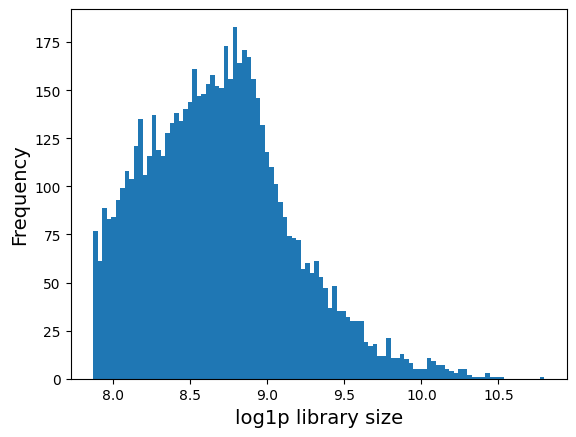

In [24]:
plt.hist(adata.obs["log1p_total_counts"], 100)
plt.xlabel("log1p library size", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

The following is the distribution of number of genes expressed in each cell. It should be correlated with library size above.

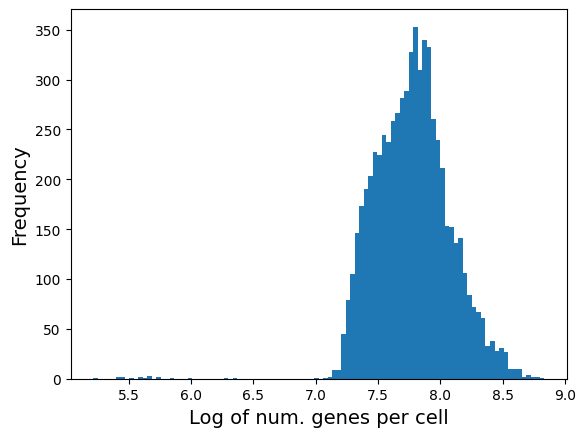

In [25]:
plt.hist(adata.obs["log1p_n_genes_by_counts"], bins=100)
plt.xlabel("Log of num. genes per cell", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
# plt.title('Histogram of number of genes expressed in each cell', fontsize = 14)
plt.show()

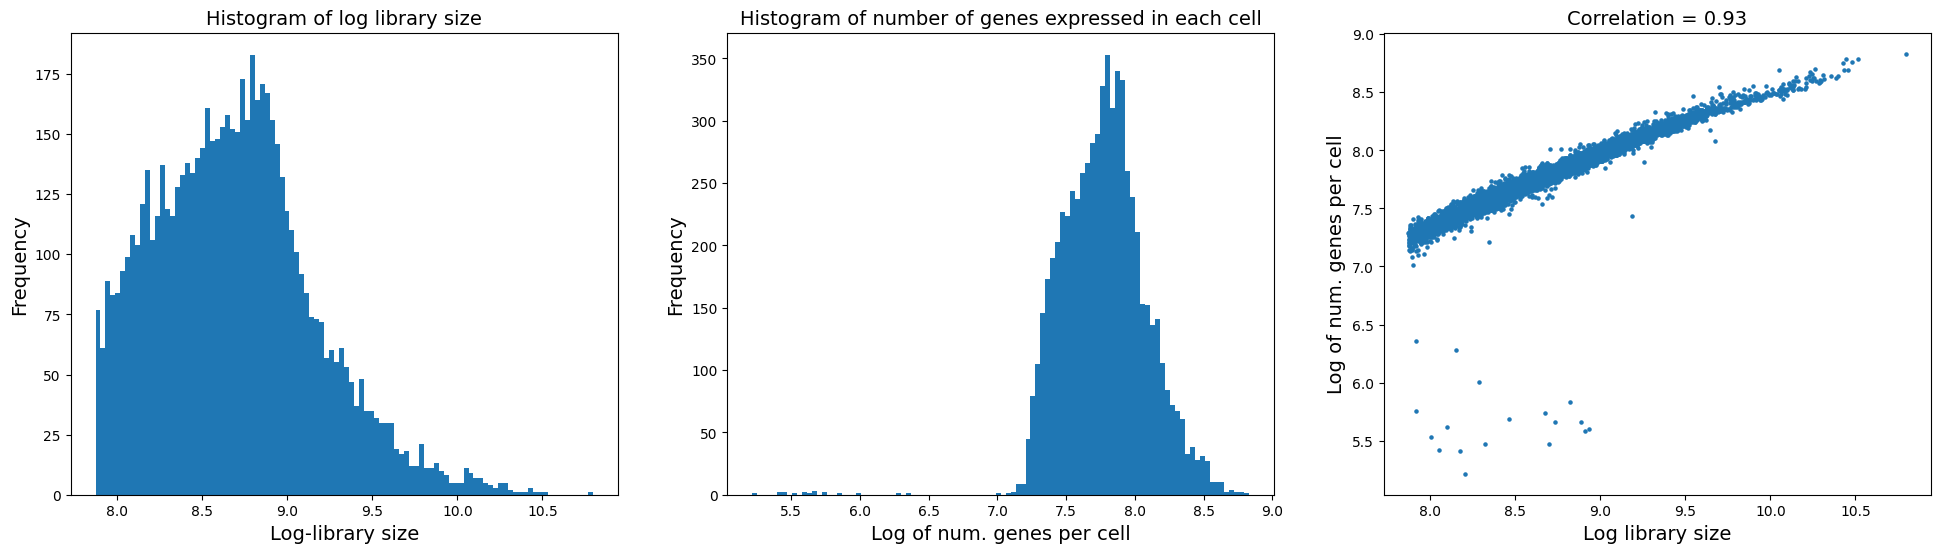

In [26]:
fig = plt.figure(figsize=(8 * 3, 6 * 1))

ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs["log1p_total_counts"], bins=100)
ax.set_xlabel("Log-library size", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Histogram of log library size", fontsize=14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(adata.obs["log1p_n_genes_by_counts"], bins=100)
ax.set_xlabel("Log of num. genes per cell", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Histogram of number of genes expressed in each cell", fontsize=14)

ax = fig.add_subplot(1, 3, 3)
x = adata.obs["log1p_total_counts"]
y = adata.obs["log1p_n_genes_by_counts"]
ax.scatter(x, y, s=5)
ax.set_ylabel("Log of num. genes per cell", fontsize=14)
ax.set_xlabel("Log library size", fontsize=14)
corr_coef = np.corrcoef(x, y)[0, 1]
ax.set_title("Correlation = " + str(round(corr_coef, 3)), fontsize=14)
plt.show()

## Visualize %MT
Compute the fraction of mitochondrial genes. Note: mitochondrial genes in human start with `'MT-'` and mouse `mt-`.

In [27]:
# Identify mitochondrial genes (mouse: 'mt-', human: 'MT-')
mt_genes = adata.var_names[adata.var_names.str.startswith("mt-")]

In [28]:
mt_genes

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object')

In [29]:
adata.var_names.is_unique

False

In [30]:
adata.var_names_make_unique()

In [31]:
adata.var_names.is_unique

True

In [32]:
adata

AnnData object with n_obs × n_vars = 6552 × 27998
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [33]:
# compute the % of mito content by dividing the above result by library size
row_sum_adata_mito = np.sum(adata[:, mt_genes].X.toarray(), axis=1)
row_sum_adata_mito

array([374., 278.,  99., ..., 532.,  78., 188.],
      shape=(6552,), dtype=float32)

In [34]:
adata.obs["mt_pct_content"] = row_sum_adata_mito / adata.obs["total_counts"] * 100

In [35]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_pct_content
AAACCTGAGAGCTTCT-1,2556,7.846590,6801.0,8.824972,23.231878,32.568740,44.081753,61.182179,5.499191
AAACCTGAGAGTACCG-1,1489,7.306531,3213.0,8.075272,29.349518,39.340181,51.229381,69.218799,8.652349
AAACCTGAGCCCTAAT-1,1910,7.555382,4086.0,8.315566,20.680372,30.323054,42.608908,61.674009,2.422908
AAACCTGAGTGGGATC-1,1926,7.563720,4511.0,8.414495,26.291288,35.668366,46.818887,64.597650,5.320328
AAACCTGCACAACTGT-1,2893,7.970395,8406.0,9.036820,23.721152,35.010707,46.157507,61.753509,4.591958
...,...,...,...,...,...,...,...,...,...
TTTGTCACATCTGGTA-1,3386,8.127700,9977.0,9.208138,20.797835,28.866393,39.400621,56.449835,2.134910
TTTGTCAGTAACGTTC-1,2003,7.602900,4563.0,8.425955,23.011177,32.982687,44.707429,62.217839,2.344949
TTTGTCAGTCTCAACA-1,3387,8.127995,10894.0,9.296060,24.664953,35.570039,47.044245,61.244722,4.883422
TTTGTCAGTGCCTGTG-1,1765,7.476472,3349.0,8.116715,21.707973,30.307554,41.415348,61.212302,2.329053


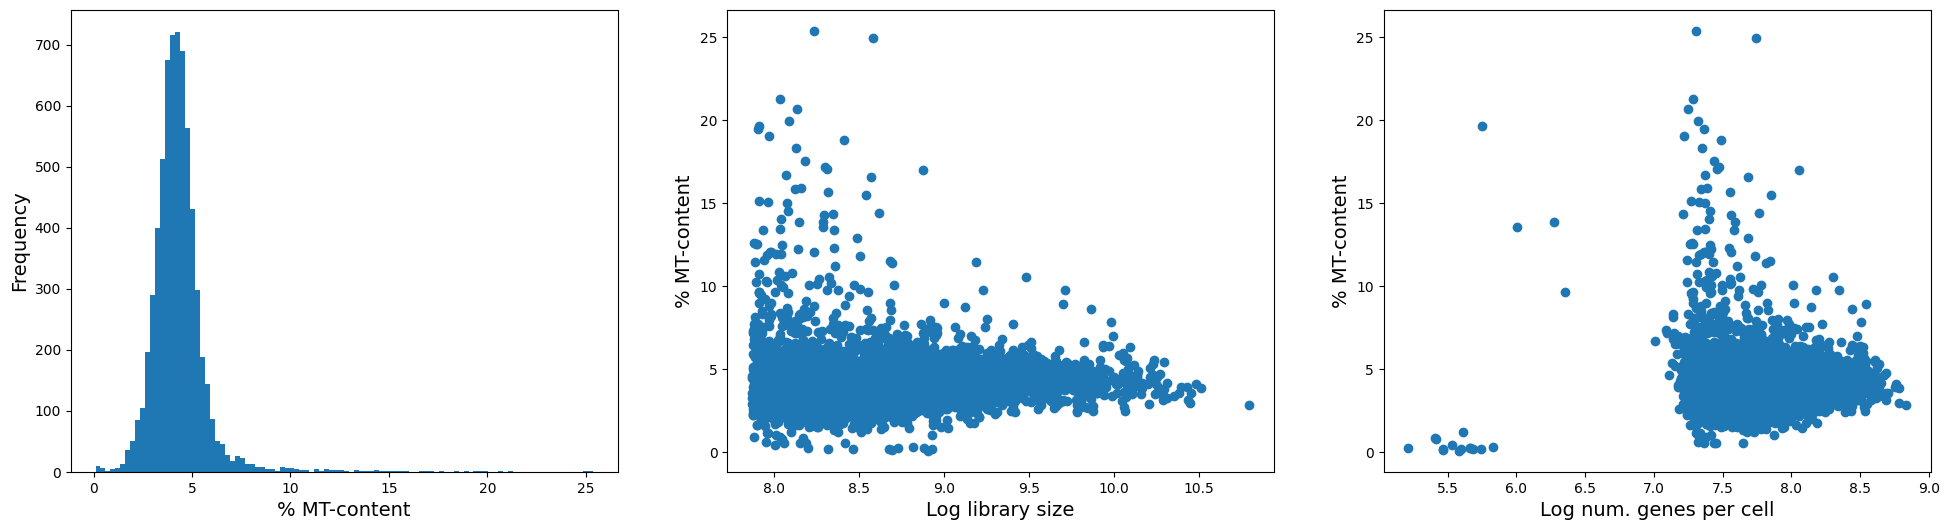

In [36]:
fig = plt.figure(figsize=(8 * 3, 6 * 1))

ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs["mt_pct_content"], 100)
ax.set_xlabel("% MT-content", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs["log1p_total_counts"], adata.obs["mt_pct_content"])
ax.set_xlabel("Log library size", fontsize=14)
ax.set_ylabel("% MT-content", fontsize=14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs["log1p_n_genes_by_counts"], adata.obs["mt_pct_content"])
ax.set_xlabel("Log num. genes per cell", fontsize=14)
ax.set_ylabel("% MT-content", fontsize=14)
plt.show()

The distribution of mitochondrial (MT) content shows a clear peak around ~4–6%, with the majority of cells falling below 10% MT content (left panel). A small subset of cells forms a long right-hand tail with substantially higher MT percentages. Inspection of the scatter plots reveals that cells with MT content above ~10% consistently exhibit lower library sizes and fewer detected genes, indicating reduced data quality. Based on this separation, we selected 10% mitochondrial content as a threshold and removed cells exceeding this value from downstream analyses.

In [37]:
# filter MT
adata_clean = adata[adata.obs["mt_pct_content"] < 10]

In [38]:
adata_clean

View of AnnData object with n_obs × n_vars = 6481 × 27998
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

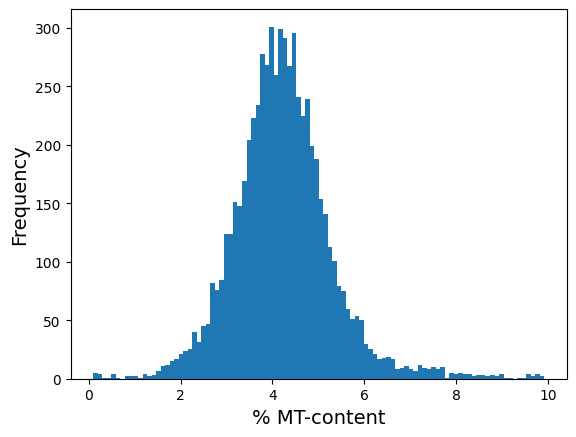

In [39]:
# just double check: there must be no cell with MT > 10
plt.hist(adata_clean.obs["mt_pct_content"], 100)
plt.xlabel("% MT-content", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

NOTE: For the sake of exposition, we will continue with original `adata` (i.e. will not use `adata_clean`).

## Visualize gene metadata

In [40]:
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_pct_content
AAACCTGAGAGCTTCT-1,2556,7.846590,6801.0,8.824972,23.231878,32.568740,44.081753,61.182179,5.499191
AAACCTGAGAGTACCG-1,1489,7.306531,3213.0,8.075272,29.349518,39.340181,51.229381,69.218799,8.652349
AAACCTGAGCCCTAAT-1,1910,7.555382,4086.0,8.315566,20.680372,30.323054,42.608908,61.674009,2.422908
AAACCTGAGTGGGATC-1,1926,7.563720,4511.0,8.414495,26.291288,35.668366,46.818887,64.597650,5.320328
AAACCTGCACAACTGT-1,2893,7.970395,8406.0,9.036820,23.721152,35.010707,46.157507,61.753509,4.591958


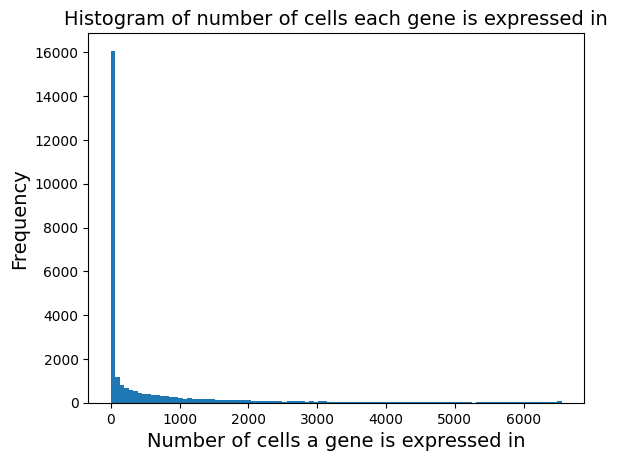

In [41]:
plt.hist(adata.var["n_cells_by_counts"], bins=100)
plt.xlabel("Number of cells a gene is expressed in", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Histogram of number of cells each gene is expressed in", fontsize=14)
plt.show()

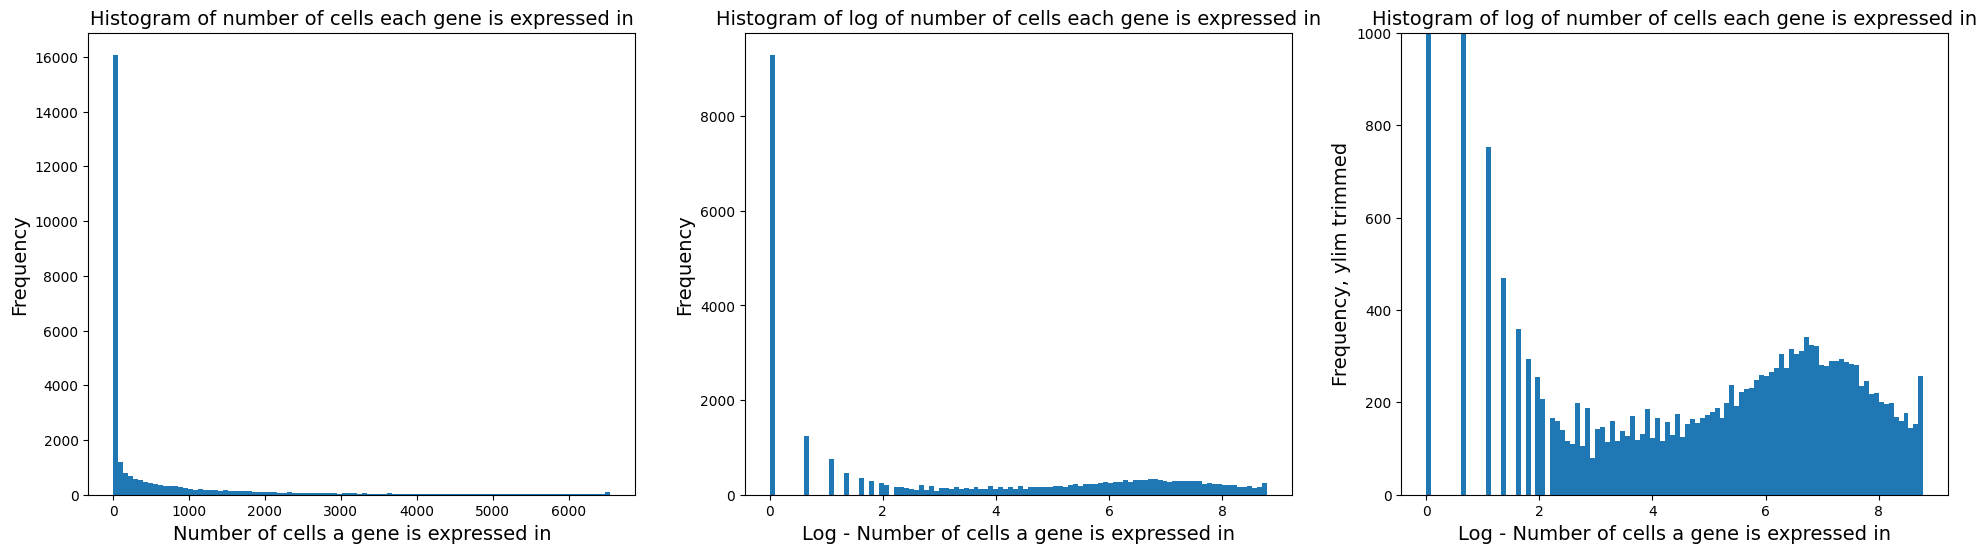

In [42]:
fig = plt.figure(figsize=(8 * 3, 6 * 1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.var["n_cells_by_counts"], bins=100)
ax.set_xlabel("Number of cells a gene is expressed in", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Histogram of number of cells each gene is expressed in", fontsize=14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(adata.var["n_cells_by_counts"] + 1), bins=100)
ax.set_xlabel("Log - Number of cells a gene is expressed in", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title(
    "Histogram of log of number of cells each gene is expressed in", fontsize=14
)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(adata.var["n_cells_by_counts"] + 1), bins=100)
ax.set_xlabel("Log - Number of cells a gene is expressed in", fontsize=14)
ax.set_ylabel("Frequency, ylim trimmed", fontsize=14)
ax.set_title(
    "Histogram of log of number of cells each gene is expressed in", fontsize=14
)
ax.set_ylim([0, 1000])
plt.show()

## Remove lowly expressed genes

In [43]:
sc.pp.filter_genes(adata, min_cells=np.exp(4))

In [44]:
adata

AnnData object with n_obs × n_vars = 6552 × 12210
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Ribosomal RNA content

In [45]:
# Identify ribo-genes
# Identify ribosomal genes (mouse: 'Rps' and 'Rpl', human: 'RPS' and 'RPL')
ribo_genes = adata.var_names[adata.var_names.str.startswith(('Rps', 'Rpl'))]
ribo_genes

Index(['Rpl7', 'Rpl31', 'Rpl37a', 'Rps6kc1', 'Rpl7a', 'Rpl12', 'Rpl35',
       'Rps21', 'Rpl39', 'Rpl10',
       ...
       'Rpl36', 'Rpl7a-ps5', 'Rpl27-ps3', 'Rps14', 'Rpl17', 'Rps6kb2',
       'Rps6ka4', 'Rpl9-ps6', 'Rpl13a-ps1', 'Rps12-ps3'],
      dtype='object', length=106)

In [46]:
# now we need the row sum of the subsetted data to compute % ribo content
row_sum_adata_ribo = np.sum(adata[:, ribo_genes].X.toarray(), axis=1)
row_sum_adata_ribo

array([ 882.,  481.,  595., ..., 2045.,  447.,  501.],
      shape=(6552,), dtype=float32)

In [47]:
# compute the % of ribo content by dividing the above result by library size
adata.obs["ribo_pct_content"] = row_sum_adata_ribo / adata.obs["total_counts"] * 100

In [48]:
adata

AnnData object with n_obs × n_vars = 6552 × 12210
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

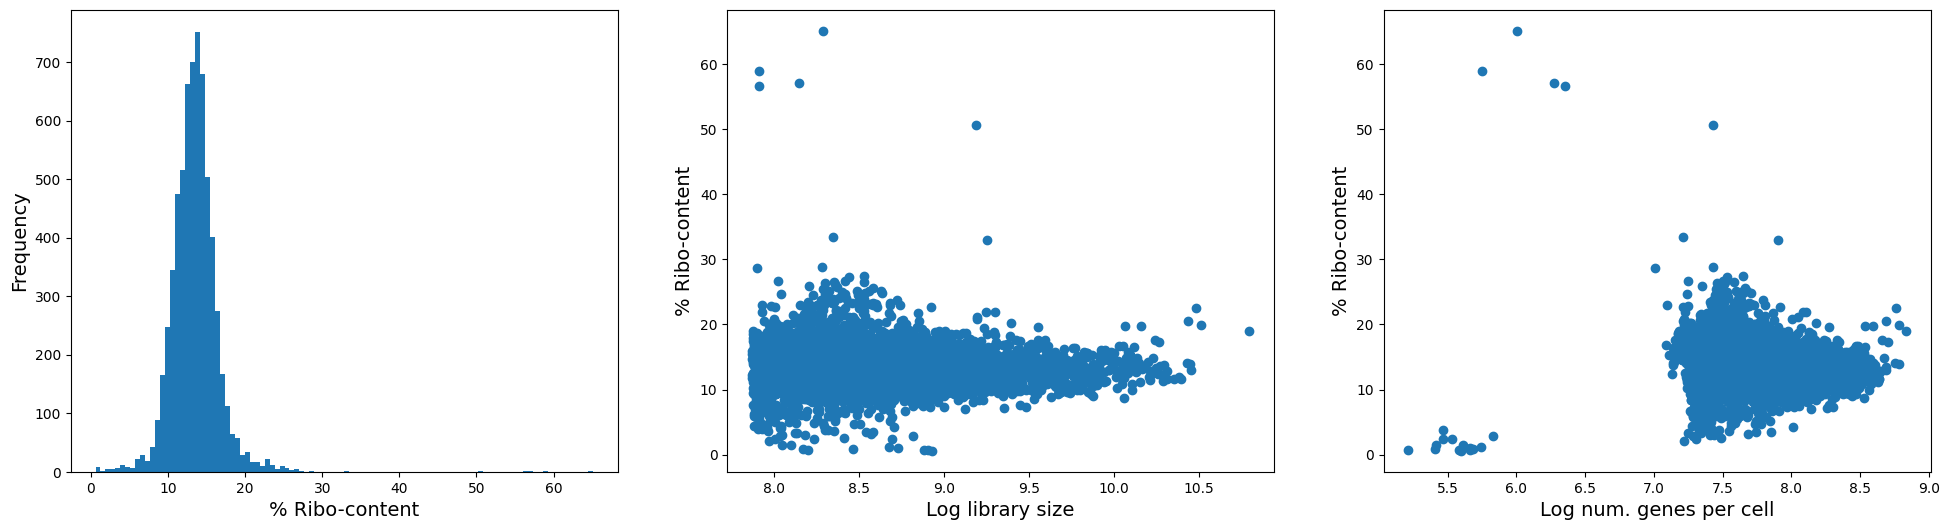

In [49]:
fig = plt.figure(figsize=(8 * 3, 6 * 1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs["ribo_pct_content"], 100)
ax.set_xlabel("% Ribo-content", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs["log1p_total_counts"], adata.obs["ribo_pct_content"])
ax.set_xlabel("Log library size", fontsize=14)
ax.set_ylabel("% Ribo-content", fontsize=14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs["log1p_n_genes_by_counts"], adata.obs["ribo_pct_content"])
ax.set_xlabel("Log num. genes per cell", fontsize=14)
ax.set_ylabel("% Ribo-content", fontsize=14)
plt.show()

Many publications often remove ribosomal genes from the beginning of their analysis because there are very limited publications which highlight their important application beisdes cell homeostasis. Here is an example of code of how you can remove ribosomal genes from your data:

In [50]:
adata_clean = adata[:, ~adata.var_names.str.startswith(("Rps", "Rpl"))]

In [51]:
adata_clean

View of AnnData object with n_obs × n_vars = 6552 × 12104
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

NOTE: For the sake of exposition, we will continue with original `adata` (i.e. will not use `adata_clean`).

## Doublet Detection and Removal

In [52]:
adata

AnnData object with n_obs × n_vars = 6552 × 12210
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [53]:
sc.pp.filter_genes(adata, min_cells=10)

In [54]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor="seurat_v3")

In [55]:
adata

AnnData object with n_obs × n_vars = 6552 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [56]:
import scvi

In [57]:
import torch
print(torch.cuda.is_available())  # Should be True for ROCm
print(torch.cuda.get_device_name(0))  # Your AMD GPU

True
AMD Radeon Graphics


In [58]:
# model setup
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train(accelerator='cpu', devices=1)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [12:00<00:00,  1.84s/it, v_num=1, train_loss=1e+3]   

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:00<00:00,  1.80s/it, v_num=1, train_loss=1e+3]


In [59]:
# SOLO model
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(accelerator='cpu', devices=1)

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Epoch 188/400:  47%|████▋     | 188/400 [01:10<01:19,  2.65it/s, v_num=1, train_loss_step=0.0825, train_loss_epoch=0.14] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.147. Signaling Trainer to stop.


In [60]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
AAACCTGAGAGCTTCT,0.005783,0.994217,singlet
AAACCTGAGAGTACCG,0.000003,0.999997,singlet
AAACCTGAGCCCTAAT,0.000006,0.999994,singlet
AAACCTGAGTGGGATC,0.000021,0.999979,singlet
AAACCTGCACAACTGT,0.034771,0.965229,singlet
...,...,...,...
TTTGTCACATCTGGTA,0.568221,0.431779,doublet
TTTGTCAGTAACGTTC,0.001856,0.998144,singlet
TTTGTCAGTCTCAACA,0.054942,0.945058,singlet
TTTGTCAGTGCCTGTG,0.000009,0.999991,singlet


In [61]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,508,508
singlet,6044,6044


In [62]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
AAACCTGAGAGCTTCT,0.005783,0.994217,singlet,-0.988435
AAACCTGAGAGTACCG,0.000003,0.999997,singlet,-0.999994
AAACCTGAGCCCTAAT,0.000006,0.999994,singlet,-0.999989
AAACCTGAGTGGGATC,0.000021,0.999979,singlet,-0.999959
AAACCTGCACAACTGT,0.034771,0.965229,singlet,-0.930458
...,...,...,...,...
TTTGTCACATCTGGTA,0.568221,0.431779,doublet,0.136442
TTTGTCAGTAACGTTC,0.001856,0.998144,singlet,-0.996288
TTTGTCAGTCTCAACA,0.054942,0.945058,singlet,-0.890116
TTTGTCAGTGCCTGTG,0.000009,0.999991,singlet,-0.999983


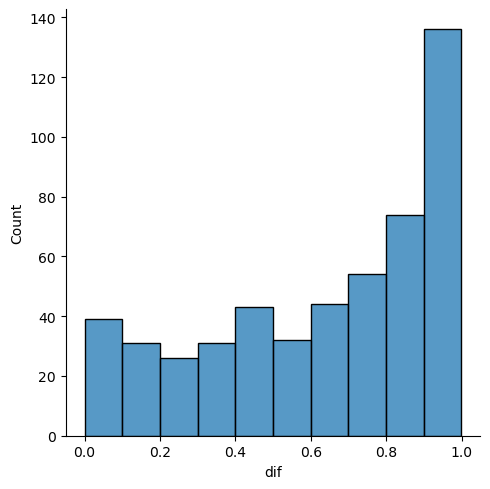

In [78]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')
plt.show()

In [63]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.8)]
doublets

,doublet,singlet,prediction,dif
AAACCTGTCGGTGTTA,0.941457,0.058543,doublet,0.882913
AAAGCAACATATGGTC,0.958349,0.041651,doublet,0.916698
AACTGGTGTCATACTG,0.982657,0.017343,doublet,0.965315
AAGGTTCCATACTCTT,0.993942,0.006058,doublet,0.987884
AATCCAGAGAGATGAG,0.963602,0.036398,doublet,0.927204
...,...,...,...,...
TTCTTAGGTATGAAAC,0.992157,0.007844,doublet,0.984313
TTGAACGTCGCCCTTA,0.992910,0.007090,doublet,0.985820
TTGACTTTCGGATGGA,0.966550,0.033450,doublet,0.933101
TTTACTGGTTACGTCA,0.994615,0.005385,doublet,0.989230


In [64]:
adata = sc.read_10x_h5(os.path.join(raw_data_dir, "GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5"))

In [65]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [66]:
adata.obs

,doublet
AAACCTGAGAGCTTCT-1,False
AAACCTGAGAGTACCG-1,False
AAACCTGAGCCCTAAT-1,False
AAACCTGAGTGGGATC-1,False
AAACCTGCACAACTGT-1,False
...,...
TTTGTCACATCTGGTA-1,False
TTTGTCAGTAACGTTC-1,False
TTTGTCAGTCTCAACA-1,False
TTTGTCAGTGCCTGTG-1,False


In [67]:
adata = adata[~adata.obs.doublet]

In [68]:
adata

View of AnnData object with n_obs × n_vars = 6552 × 27998
    obs: 'doublet'
    var: 'gene_ids'

## Data Normalization
One of the most common normalization methods is median library size normalization followed by log-transformation. Median library size normalization is inspired from normalization techniques in bulk data (Transcript Per Million or TPM normalization). This approach aims to normalize the library size of all cells to the same value, which is usually set to be the median library size in the data. The assumption here is that all cells in a sample should have the same total number of RNA counts. Obviously this is not necessarily an adequate assumption and in many circumstances is false (for example, a sample with cells of different sizes or at different stages of activation can have different total RNA). However, this is still the most common kind of normalization being used.

The normalization step is followed by a log transformation of the data. This step is done primarily to normalize for the differences in gene expression scales. Of note, scRNA-seq data is massively undersampled, which means many of the entries are 0 thus taking log of the data can be problematic. As such, it is typical to add a non-zero pseudocount (typically 0.1 or 1) to the data. It is generally wise to ensure that zeros remain as zeros post log-transformation. So, it is common to add 1 to the data before taking log of the data: `adata.X = np.log(adata.X + 1)` or adding and subtracting 0.1: `adata.X = np.log(adata.X + 0.1) - np.log(0.1)`. Either way, zeros before log remain as zeros.

Before we apply this normalization step, one very important note on Scanpy's data structure: The main data on which processing is to be done is stored in `adata.X`. So if we normalize the data in place then the original raw data will be replaced by the new normalized counts and we will lose the original counts. To avoid this from happening, we will store the original raw counts in adata.layers as follows. It is wise to save original counts for later, as we may require them for downstream analysis (e.g. count based factor analysis methods).

In [69]:
adata.layers["raw_data"] = adata.X.copy()

Now that we have made a copy of the original counts, we can go ahead and apply Scanpy's normalization function.

In [70]:
sc.pp.normalize_total(adata, inplace=True)

We can now log transform the data as follows (Note - we did not save normalized data in layers as raw_data because we can always recompute it if needed):

In [71]:
sc.pp.log1p(adata)

In [72]:
adata

AnnData object with n_obs × n_vars = 6552 × 27998
    obs: 'doublet'
    var: 'gene_ids'
    uns: 'log1p'
    layers: 'raw_data'

## Save results for future

In [73]:
processed_data_dir

'/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/Neurogenomics-Codings/sc-neuro/processed_data'

In [74]:
# export processed adata
adata.write(os.path.join(processed_data_dir, "GSM4635080_P1_S1_processed_adata.h5ad"))